# Data Assignment 3 - `t54zheng` (20939203)


In [1]:
import pandas as pd
from pandasql import sqldf
import matplotlib.pyplot as plt
import numpy as np
import warnings
from sklearn import linear_model
import statsmodels.api as sm
import scipy.stats as stats
from math import sqrt

warnings.filterwarnings('ignore')

In [2]:
crsp = pd.read_excel("datasets.xlsx", sheet_name="crsp", converters={"DATE":str})
ff3 = pd.read_excel("datasets.xlsx", sheet_name="ff3", converters={"DATEFF":str})
merged = pd.read_excel("datasets.xlsx", sheet_name="merged_compustat_crsp") # Contains our variables from Assignment 2

# Task 1 - Estimating Beta for each stock

- We wish to estimate the beta for each stock using the CAPM model for every month t between January 2000 and December 2022
- We will use an observation window of the past 36 months for each stock.

Some stocks may not have data until after Janurary 2000, so if that happens we only look at months t such that there are at least 12 observations prior to (not including) t.

In [3]:
nasdaq_100_ret = crsp[["PERMNO", "DATE", "RET"]]

In [4]:
# Data cleanup
nasdaq_100_ret.dropna(inplace=True)

In [5]:
ff3

,DATEFF,SMB,HML,MKTRF,RF,UMD
0,1980-01-31 00:00:00,0.0162,0.0175,0.0551,0.0080,0.0755
1,1980-02-29 00:00:00,-0.0185,0.0061,-0.0122,0.0089,0.0788
2,1980-03-31 00:00:00,-0.0664,-0.0101,-0.1290,0.0121,-0.0955
3,1980-04-30 00:00:00,0.0105,0.0106,0.0397,0.0126,-0.0043
4,1980-05-30 00:00:00,0.0213,0.0038,0.0526,0.0081,-0.0112
...,...,...,...,...,...,...
523,2023-08-31 00:00:00,-0.0316,-0.0106,-0.0239,0.0045,0.0377
524,2023-09-29 00:00:00,-0.0251,0.0152,-0.0524,0.0043,0.0026
525,2023-10-31 00:00:00,-0.0387,0.0019,-0.0319,0.0047,0.0173
526,2023-11-30 00:00:00,-0.0002,0.0164,0.0884,0.0044,0.0275


In [6]:
permnos = set(list(nasdaq_100_ret.PERMNO))

In [7]:
len(permnos)

99

In [8]:
permno_beta_dict = {}

# Filter into dicts, while removing rows with null returns
for permno in permnos:
    permno_returns = nasdaq_100_ret.loc[nasdaq_100_ret["PERMNO"] == permno]
    permno_returns.reset_index(inplace=True) # Reset index for easy accessing later on

    # Calculate beta using 36 month lookback starting in 2000

    # Start date is first date where we have >= 12 observations for a beta observation
    # Start date needs to be past 2000-01-01
    permno_betas = {}
    for t in range(11, len(permno_returns["DATE"])):
        # Don't predict if date is not on or after 2000-01-01
        if permno_returns.iloc[t].DATE < "2000-01-01":
            continue

        date = permno_returns.iloc[t].DATE
        est_window_start = t - 35 if t > 35 else 0

        # Because indexing ends at i - 1
        est_window_end = t + 1

        
        est_window_returns = permno_returns.iloc[est_window_start:est_window_end].RET
        est_window_returns_dates = permno_returns.iloc[est_window_start:est_window_end].DATE

        date_mask = ff3["DATEFF"].isin(est_window_returns_dates)
        rf = ff3[date_mask]["RF"]
        mktrf = ff3[date_mask][["MKTRF"]]

        CAPMmodel = linear_model.LinearRegression().fit(mktrf, est_window_returns.values - rf.values)

        permno_betas[date] = CAPMmodel.coef_[0]
    permno_beta_dict[permno] = permno_betas


In [9]:
for permno in permno_beta_dict:
    permno_beta_dict[permno] = pd.DataFrame.from_dict(permno_beta_dict[permno], orient="index", columns = ["beta"])

In [10]:
permno_beta_dict[87055].reset_index()

,index,beta
0,2000-01-31 00:00:00,1.168141
1,2000-02-29 00:00:00,1.151875
2,2000-03-31 00:00:00,1.228568
3,2000-04-28 00:00:00,1.161269
4,2000-05-31 00:00:00,1.351509
...,...,...
271,2022-08-31 00:00:00,0.583513
272,2022-09-30 00:00:00,0.628876
273,2022-10-31 00:00:00,0.628439
274,2022-11-30 00:00:00,0.643019


## Summary Statistics

For each variable, we will aggregate them since it appears that we are interested in their aggregate correlation in the assignment.

Furthermore, since each factor should be independent of the stock once isolated, we can presume that this is the justified approach.

In [11]:
def print_summary_statistics(series):
    N = len(series)
    mean = series.mean()
    std = series.std()
    median = series.median()
    minimum = min(series)
    q_1 = np.percentile(series, 1)
    q_99 = np.percentile(series, 99)
    maximum = max(series)


    print(f"N: {N}")
    print(f"mean: {mean:.4f}")
    print(f"standard deviation: {std:.4f}")
    print(f"median: {median:.4f}")
    print(f"minimum: {minimum:.4f}")
    print(f"1st Percentile: {q_1:.4f}")
    print(f"99th Percentile: {q_99:.4f}")
    print(f"maximum: {maximum:.4f}")

In [12]:
beta_dfs = []
for permno in permnos:
    betas = permno_beta_dict[permno].reset_index()
    betas.loc[:,"PERMNO"] = permno
    beta_dfs.append(betas)
aggregate_betas_df = pd.concat(beta_dfs, ignore_index=True)
aggregate_betas_df.columns = ["DATE", "beta", "PERMNO"]
print("----------------------------------------")
print("Summary Statistics for [ beta ] variable")
print("----------------------------------------")
print_summary_statistics(aggregate_betas_df['beta'])

----------------------------------------
Summary Statistics for [ beta ] variable
----------------------------------------
N: 21481
mean: 1.2417
standard deviation: 0.7829
median: 1.1043
minimum: -2.2283
1st Percentile: -0.1209
99th Percentile: 3.8351
maximum: 7.3953


***
## Task 2 - Calculating `ivol`
- Assuming that we need to download the daily factors from Jan 2000-Dec 2022 since we change to monthly frequency at the end
    - So that we match the number of observations (or close to) for Task 1
- WRDS Queries:
    - [8146227](https://wrds-www.wharton.upenn.edu/query-manager/query/8146227/)
    - [8146249](https://wrds-www.wharton.upenn.edu/query-manager/query/8146249/)

In [13]:
# Import data
crsp_daily = pd.read_sas("nasdaq_100_crsp_daily.sas7bdat", encoding = 'ISO-8859-1')
ff3_daily = pd.read_sas("ff_factors_daily.sas7bdat", encoding = 'ISO-8859-1')

In [14]:
# Data Cleanup
crsp_daily.dropna(inplace=True, ignore_index=True)
ff3_daily.dropna(inplace=True, ignore_index=True)

In [15]:
ff3_daily.set_index("DATE", inplace=True)
ff3_daily

,MKTRF,SMB,HML,RF
DATE,,,,
2000-01-03,-0.0071,0.0062,-0.0141,0.00021
2000-01-04,-0.0406,0.0000,0.0206,0.00021
2000-01-05,-0.0009,0.0020,0.0016,0.00021
2000-01-06,-0.0073,-0.0043,0.0126,0.00021
2000-01-07,0.0321,-0.0048,-0.0142,0.00021
...,...,...,...,...
2022-12-23,0.0051,-0.0061,0.0116,0.00016
2022-12-27,-0.0051,-0.0074,0.0142,0.00016
2022-12-28,-0.0123,-0.0024,-0.0029,0.00016


## Running the Regression

Ang. et al. cites the FF3 Model

$$ r_t^i = \alpha^i + \beta^i_{MKT}{MKT}_t + \beta^i_{SMB}{SMB}_t + \beta^a_{HML}{HML}_t + \epsilon^{i}_t$$ 

for security $i$ at time $t$


That is, for our regression, for each stock and for each month, we run the ff3 regression, using data from both at day ($t$).

In our initial regression, we obtain for each security $i$:
- Each factor beta
- Our alpha coefficient

Then using the values from above we calculate
- our epsilon for each time

### Why is this not look-ahead bias?
- Because the epsilons are actually part of the portfilio.
- An investor would use this data calculated from month $t-1$ to make their decision in what to invest in for month $t$ if they are interested in the stock's idiosyncratic risk.

In [16]:
permnos = set(list(crsp_daily["PERMNO"]))

ff3_daily

,MKTRF,SMB,HML,RF
DATE,,,,
2000-01-03,-0.0071,0.0062,-0.0141,0.00021
2000-01-04,-0.0406,0.0000,0.0206,0.00021
2000-01-05,-0.0009,0.0020,0.0016,0.00021
2000-01-06,-0.0073,-0.0043,0.0126,0.00021
2000-01-07,0.0321,-0.0048,-0.0142,0.00021
...,...,...,...,...
2022-12-23,0.0051,-0.0061,0.0116,0.00016
2022-12-27,-0.0051,-0.0074,0.0142,0.00016
2022-12-28,-0.0123,-0.0024,-0.0029,0.00016


In [17]:
crsp_daily

,PERMNO,DATE,RET
0,10107.0,2000-01-03,-0.001606
1,10107.0,2000-01-04,-0.033780
2,10107.0,2000-01-05,0.010544
3,10107.0,2000-01-06,-0.033498
4,10107.0,2000-01-07,0.013068
...,...,...,...
460352,93436.0,2022-12-23,-0.017551
460353,93436.0,2022-12-27,-0.114089
460354,93436.0,2022-12-28,0.033089
460355,93436.0,2022-12-29,0.080827


In [18]:
# Merge the dataset
                                                  # want all data from ff3_daily  
ff3_crsp_merged = pd.merge(crsp_daily, ff3_daily, how='right', on='DATE')
ff3_crsp_merged

,PERMNO,DATE,RET,MKTRF,SMB,HML,RF
0,10107.0,2000-01-03,-0.001606,-0.0071,0.0062,-0.0141,0.00021
1,10145.0,2000-01-03,-0.017335,-0.0071,0.0062,-0.0141,0.00021
2,10696.0,2000-01-03,-0.004894,-0.0071,0.0062,-0.0141,0.00021
3,11403.0,2000-01-03,-0.080729,-0.0071,0.0062,-0.0141,0.00021
4,11618.0,2000-01-03,-0.055633,-0.0071,0.0062,-0.0141,0.00021
...,...,...,...,...,...,...,...
460352,92221.0,2022-12-30,-0.023133,-0.0022,0.0012,-0.0003,0.00016
460353,93002.0,2022-12-30,0.002366,-0.0022,0.0012,-0.0003,0.00016
460354,93089.0,2022-12-30,-0.009210,-0.0022,0.0012,-0.0003,0.00016
460355,93132.0,2022-12-30,-0.006503,-0.0022,0.0012,-0.0003,0.00016


### Implementing the regression
- Like discussed above we run the regression then calculate each month's epsilon
- For any month with less than 10 measurements, we drop it.
- When we calculate the standard deviation of each day's returns, we end up with a daily volatility
- **We want a monthly volatility so we multiply by the square root of the number of days (number of observations)**

In [19]:
permno_ivol_dict = {}

for permno in permnos:
    monthly_ivols = {}
    permno_stats = ff3_crsp_merged[ff3_crsp_merged["PERMNO"] == permno]
    permno_stats.reset_index(inplace=True)

    # Group by dates
    permno_stats["DATE"] = permno_stats["DATE"].dt.strftime("%Y-%m")
    year_month_groups = list(set(list(permno_stats["DATE"])))
    year_month_groups.sort()
    # Iterate
    for year_month in year_month_groups:
        year_month_data = permno_stats[permno_stats["DATE"] == year_month]
        if len(year_month_data) < 10:
            continue # drop regression if less than 10 observations in a month
        stock_rets = year_month_data["RET"] # Our explanatory variable (stock returns [not excess returns])
        ff3_factors = year_month_data[["MKTRF", "SMB", "HML"]]

        # Run the regression for the month's data
        FF3Model = linear_model.LinearRegression(n_jobs=3).fit(ff3_factors, stock_rets)

        # Get our beta_i's and alpha_i
        mkt_beta = FF3Model.coef_[0]
        smb_beta = FF3Model.coef_[1]
        hml_beta = FF3Model.coef_[2]
        ff3_alpha = FF3Model.intercept_

        # Calculate our epsilons (Actual return - model prediction)
                                     # Actual return
        year_month_data["epsilon"] = year_month_data["RET"] - \
                                        (mkt_beta * year_month_data["MKTRF"] + smb_beta * year_month_data["SMB"] + hml_beta * year_month_data["HML"] + ff3_alpha) # Model

        monthly_ivols[year_month] = year_month_data["epsilon"].std() * sqrt(len(year_month_data["epsilon"])) # Make std monthly
    permno_ivol_dict[permno] = monthly_ivols

In [20]:
for permno in permnos:
    permno_ivol_dict[permno] = pd.DataFrame.from_dict(permno_ivol_dict[permno], orient="index", columns=["ivol"])

In [21]:
permno_ivol_dict[87055.0]

,ivol
2000-01,0.089021
2000-02,0.155362
2000-03,0.190532
2000-04,0.134467
2000-05,0.253236
...,...
2022-08,0.035299
2022-09,0.054653
2022-10,0.053837
2022-11,0.032444


## Summary Statistics
* Like for betas, we will be reporting them in aggregate

In [22]:
ivol_dfs = []
for permno in permnos:
    ivol = permno_ivol_dict[permno].reset_index()
    ivol.loc[:,"PERMNO"] = permno
    ivol_dfs.append(ivol)
aggregate_ivol_df = pd.concat(ivol_dfs, ignore_index=True)
aggregate_ivol_df.columns = ["DATE", "ivol", "PERMNO"]

print("----------------------------------------")
print("Summary Statistics for [ ivol ] variable")
print("----------------------------------------")
print_summary_statistics(aggregate_ivol_df['ivol'])

----------------------------------------
Summary Statistics for [ ivol ] variable
----------------------------------------
N: 21952
mean: 0.0763
standard deviation: 0.0557
median: 0.0604
minimum: 0.0060
1st Percentile: 0.0189
99th Percentile: 0.2845
maximum: 1.0141


***
## Task 3 - Calculating `mom`

In [23]:
nasdaq_100_ret

,PERMNO,DATE,RET
0,10107,1997-01-31 00:00:00,0.234493
1,10107,1997-02-28 00:00:00,-0.044118
2,10107,1997-03-31 00:00:00,-0.059615
3,10107,1997-04-30 00:00:00,0.325153
4,10107,1997-05-30 00:00:00,0.020576
...,...,...,...
23992,93436,2022-08-31 00:00:00,-0.072489
23993,93436,2022-09-30 00:00:00,-0.037589
23994,93436,2022-10-31 00:00:00,-0.142168
23995,93436,2022-11-30 00:00:00,-0.144326


## Data Correction
- Since some periods can have less than 12 observations (10, or 11), we get the geometric mean return and then compound to 12 periods
- This way, all of our data points correctly showcase a 12-month compound return.

In [24]:
permno_mom_dict = {}

for permno in permnos:
    monthly_mom = {}
    permno_returns = nasdaq_100_ret.loc[nasdaq_100_ret["PERMNO"] == permno]
    permno_returns.reset_index(inplace=True) # Reset index for easy accessing later on
    
    for t in range(9, len(permno_returns["DATE"])):
        # Don't predict if date is not on or after 2000-01-01
        if permno_returns.iloc[t].DATE < "2000-01-01":
            continue
    
        date = permno_returns.iloc[t].DATE
        est_window_start = t - 11 if t > 10 else 0

        # Because indexing ends at i - 1
        est_window_end = t + 1
    
        est_window_returns = permno_returns.iloc[est_window_start:est_window_end].RET

        # Going to get the monthly geometric mean return first in the case of weird months
        # So our mom characteristic has the correct magnitude assuming 12 samples
        
        comp_ret = stats.gmean(est_window_returns + 1) ** 12
        comp_ret -= 1
        monthly_mom[date] = comp_ret
    permno_mom_dict[permno] = monthly_mom

In [25]:
for permno in permnos:
    permno_mom_dict[permno] = pd.DataFrame.from_dict(permno_mom_dict[permno], orient="index", columns=["mom"])

In [26]:
permno_mom_dict[87055.0]

,mom
2000-01-31 00:00:00,0.180995
2000-02-29 00:00:00,0.235798
2000-03-31 00:00:00,0.148123
2000-04-28 00:00:00,0.335907
2000-05-31 00:00:00,-0.118966
...,...
2022-08-31 00:00:00,0.153688
2022-09-30 00:00:00,0.057838
2022-10-31 00:00:00,0.027086
2022-11-30 00:00:00,0.006445


## Summary Statistics

In [27]:
mom_dfs = []
for permno in permnos:
    mom = permno_mom_dict[permno].reset_index()
    mom.loc[:,"PERMNO"] = permno
    mom_dfs.append(mom)
aggregate_mom_df = pd.concat(mom_dfs, ignore_index=True)
aggregate_mom_df.columns = ["DATE", "mom", "PERMNO"]

print("----------------------------------------")
print("Summary Statistics for [ mom ] variable")
print("----------------------------------------")
print_summary_statistics(aggregate_mom_df['mom'])

----------------------------------------
Summary Statistics for [ mom ] variable
----------------------------------------
N: 21565
mean: 0.2610
standard deviation: 0.7422
median: 0.1655
minimum: -0.9723
1st Percentile: -0.6760
99th Percentile: 2.7300
maximum: 26.3729


***
## Task 4 - Winsorize

We'll winsorize our three statistics below.
- Since the assignment does not specify whether the specific method of winsoration we will do the following
- We will winsortize globally. That is, we winsortize based on the entire sample size
- The justification for doing so is because we learned in class that each stock is just a product of its underlying factors, so once isolated they are equal

In [28]:
def winsorize(month_section):
    for col in month_section.columns:
        if col in ("DATE", "PERMNO"):
            continue
        mean = month_section[col].mean()
        std = month_section[col].std()

        upper = mean + 3 * std
        lower = mean - 3 * std

        month_section[col] = np.clip(month_section[col], lower, upper)
    return month_section

In [29]:
winsorized_aggregate_betas_df = aggregate_betas_df.copy()
winsorized_aggregate_ivol_df = aggregate_ivol_df.copy()
winsorized_aggregate_mom_df = aggregate_mom_df.copy()

winsorized_aggregate_betas_df = winsorized_aggregate_betas_df.groupby(winsorized_aggregate_betas_df["DATE"]).apply(winsorize)
winsorized_aggregate_ivol_df = winsorized_aggregate_ivol_df.groupby(winsorized_aggregate_ivol_df["DATE"]).apply(winsorize)
winsorized_aggregate_mom_df = winsorized_aggregate_mom_df.groupby(winsorized_aggregate_mom_df["DATE"]).apply(winsorize)

winsorized_aggregate_betas_df.set_index("DATE", inplace=True)
winsorized_aggregate_ivol_df.set_index("DATE", inplace=True)
winsorized_aggregate_mom_df.set_index("DATE", inplace=True)

winsorized_aggregate_betas_df.reset_index(inplace=True)
winsorized_aggregate_ivol_df.reset_index(inplace=True)
winsorized_aggregate_mom_df.reset_index(inplace=True)

## Summary Statistics
* Again, we report our summary statistics in aggregation, not by individual stock

In [30]:
# BETA
# winsorized_aggregate_betas_df.columns = ["DATE", "beta", "PERMNO"]
print("-----------------------------------------------------")
print("Summary Statistics for [ beta ] variable (winsorized)")
print("-----------------------------------------------------")
print_summary_statistics(winsorized_aggregate_betas_df['beta'])

# IVOL
print("-----------------------------------------------------")
print("Summary Statistics for [ ivol ] variable (winsorized)")
print("-----------------------------------------------------")
print_summary_statistics(winsorized_aggregate_ivol_df['ivol'])

# MOM
winsorized_aggregate_mom_df.columns = ["DATE", "mom", "PERMNO"]
print("-----------------------------------------------------")
print("Summary Statistics for [ mom ] variable (winsorized)")
print("-----------------------------------------------------")
print_summary_statistics(winsorized_aggregate_mom_df['mom'])

-----------------------------------------------------
Summary Statistics for [ beta ] variable (winsorized)
-----------------------------------------------------
N: 21481
mean: 1.2396
standard deviation: 0.7679
median: 1.1043
minimum: -2.0165
1st Percentile: -0.1209
99th Percentile: 3.8008
maximum: 5.8011
-----------------------------------------------------
Summary Statistics for [ ivol ] variable (winsorized)
-----------------------------------------------------
N: 21952
mean: 0.0754
standard deviation: 0.0518
median: 0.0604
minimum: 0.0060
1st Percentile: 0.0189
99th Percentile: 0.2669
maximum: 0.5325
-----------------------------------------------------
Summary Statistics for [ mom ] variable (winsorized)
-----------------------------------------------------
N: 21565
mean: 0.2436
standard deviation: 0.5649
median: 0.1655
minimum: -0.9723
1st Percentile: -0.6750
99th Percentile: 2.2863
maximum: 10.1792


***
## Task 5 - Correlation between `beta` and `ivol`
- We will compare the correlation between beta and ivol

In [31]:
# We'll make our betas df have matching dates
winsorized_aggregate_betas_df["DATE"] = pd.to_datetime(winsorized_aggregate_betas_df["DATE"])
winsorized_aggregate_betas_df["DATE"] = winsorized_aggregate_betas_df["DATE"].dt.strftime("%Y-%m")

In [32]:
winsorized_aggregate_betas_df

,DATE,beta,PERMNO
0,2000-01,1.168141,87055
1,2000-01,2.571607,80924
2,2000-01,1.299417,13856
3,2000-01,1.957741,76841
4,2000-01,-0.008922,24109
...,...,...,...
21476,2022-12,0.153500,77274
21477,2022-12,1.084448,18911
21478,2022-12,0.710887,88031
21479,2022-12,1.193441,15850


In [33]:
winsorized_aggregate_ivol_df

,DATE,ivol,PERMNO
0,2000-01,0.089021,87055.0
1,2000-01,0.109423,80924.0
2,2000-01,0.099354,13856.0
3,2000-01,0.272320,76841.0
4,2000-01,0.072090,24109.0
...,...,...,...
21947,2022-12,0.035648,77274.0
21948,2022-12,0.100981,18911.0
21949,2022-12,0.032336,88031.0
21950,2022-12,0.102945,15850.0


In [34]:
# Next we join the two above dataframes so we have matching date and permno for each "point"\
beta_ivol_combined = pd.merge(winsorized_aggregate_betas_df, winsorized_aggregate_ivol_df, how="inner", on=["DATE", "PERMNO"])
beta_ivol_combined.reset_index(inplace=True)

In [35]:
beta_ivol_combined

,index,DATE,beta,PERMNO,ivol
0,0,2000-01,1.168141,87055,0.089021
1,1,2000-01,2.571607,80924,0.109423
2,2,2000-01,1.299417,13856,0.099354
3,3,2000-01,1.957741,76841,0.272320
4,4,2000-01,-0.008922,24109,0.072090
...,...,...,...,...,...
21476,21476,2022-12,0.153500,77274,0.035648
21477,21477,2022-12,1.084448,18911,0.100981
21478,21478,2022-12,0.710887,88031,0.032336
21479,21479,2022-12,1.193441,15850,0.102945


In [36]:
# Run Regression
r_val = stats.linregress(list(beta_ivol_combined["beta"]), list(beta_ivol_combined["ivol"]))[2]
print(f'r-value for beta and ivol is {r_val:.4f}')

r-value for beta and ivol is 0.3636


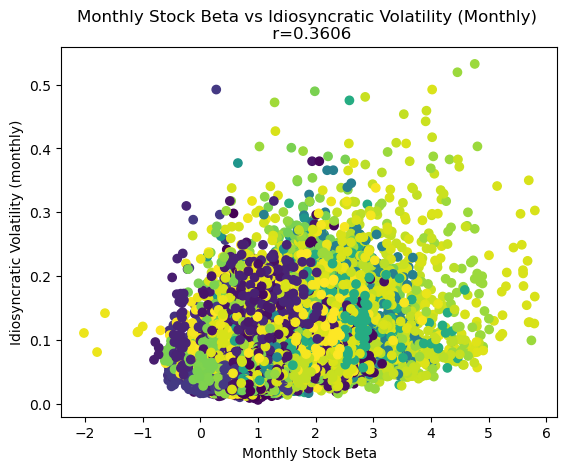

In [66]:
# Plot
# Coloured by permno
plt.scatter(x = beta_ivol_combined["beta"], y = beta_ivol_combined["ivol"], c=beta_ivol_combined["PERMNO"])


plt.title("Monthly Stock Beta vs Idiosyncratic Volatility (Monthly) \n r=0.3606")
plt.xlabel("Monthly Stock Beta")
plt.ylabel("Idiosyncratic Volatility (monthly)")
plt.show()

### Explanation in report

***
## Task 6 - Looking for Linear Relations

We will create a dataframe with all of our variables, and add $t+1$ returns

In [38]:
# Add mom variable
winsorized_aggregate_mom_df["DATE"] = pd.to_datetime(winsorized_aggregate_mom_df["DATE"])
winsorized_aggregate_mom_df["DATE"] = winsorized_aggregate_mom_df["DATE"].dt.strftime("%Y-%m")
aggregate_df = pd.merge(beta_ivol_combined, winsorized_aggregate_mom_df, how="inner", on=["DATE", "PERMNO"])

# Now we add the t+1 returns
t_plus_one_rets = nasdaq_100_ret.copy()
t_plus_one_rets["DATE"] = pd.to_datetime(t_plus_one_rets["DATE"])

# Subtract one month to each date to get t+1 return
t_plus_one_rets["DATE"] -= pd.DateOffset(months=1)
t_plus_one_rets["DATE"] = t_plus_one_rets["DATE"].dt.strftime("%Y-%m")
t_plus_one_rets.columns = ['PERMNO', 'DATE', 'T+1 RET']

aggregate_df = pd.merge(aggregate_df, t_plus_one_rets, how="inner", on=["DATE", "PERMNO"])

In [39]:
aggregate_df

,index,DATE,beta,PERMNO,ivol,mom,T+1 RET
0,0,2000-01,1.168141,87055,0.089021,0.180995,0.014049
1,1,2000-01,2.571607,80924,0.109423,0.221402,0.474320
2,2,2000-01,1.299417,13856,0.099354,-0.111746,-0.058608
3,3,2000-01,1.957741,76841,0.272320,3.997525,0.116394
4,4,2000-01,-0.008922,24109,0.072090,-0.185347,-0.142537
...,...,...,...,...,...,...,...
21376,21378,2022-11,0.136779,77274,0.041172,0.333427,-0.014232
21377,21379,2022-11,1.075103,18911,0.092012,-0.574962,-0.030087
21378,21380,2022-11,0.725484,88031,0.065434,0.227739,-0.012930
21379,21381,2022-11,1.165856,15850,0.152171,-0.611047,-0.179391


In [40]:
# Add from last assignment - note that these have already been adjusted to remove look-ahead bias
merged["DATE"] = pd.to_datetime(merged["DATE"])
merged["DATE"] = merged["DATE"].dt.strftime("%Y-%m")
aggregate_df = pd.merge(aggregate_df, merged[["DATE", "PERMNO", "lnSize", "bk2mkt", "eP2", "RET"]], how="inner", on=["DATE", "PERMNO"])

# # Reorganize
aggregate_df = aggregate_df.iloc[:, 1:]
aggregate_df.columns = ['DATE', 'beta', 'PERMNO', 'ivol', 'mom', 'T+1 RET', 'lnSize', 'bk2mkt', 'eP2', 'RET']
aggregate_df = aggregate_df[['DATE', 'PERMNO', 'beta', 'ivol', 'mom', 'lnSize', 'bk2mkt', 'eP2', 'RET', 'T+1 RET']]

In [41]:
aggregate_df.sort_values(by=["PERMNO", "DATE"], inplace=True, ignore_index=True)
aggregate_df

,DATE,PERMNO,beta,ivol,mom,lnSize,bk2mkt,eP2,RET,T+1 RET
0,2000-01,10107,1.431645,0.104978,0.118571,26.947898,12.730325,0.004393,-0.161670,-0.086845
1,2000-02,10107,1.403373,0.079473,0.190674,26.857048,11.624754,0.004811,-0.086845,0.188811
2,2000-03,10107,1.429994,0.150097,0.185495,27.045764,14.039184,0.004047,0.188811,-0.343529
3,2000-04,10107,1.599818,0.162569,-0.142198,26.628771,8.139905,0.006738,-0.343529,-0.103047
4,2000-05,10107,1.680414,0.079099,-0.224632,26.520020,7.301116,0.007512,-0.103047,0.278721
...,...,...,...,...,...,...,...,...,...,...
21160,2022-07,93436,2.424450,0.107097,0.297221,27.559644,14.099619,0.003590,0.323765,-0.072489
21161,2022-08,93436,2.419975,0.086227,0.123838,27.484394,13.077556,0.011611,-0.072489,-0.037589
21162,2022-09,93436,2.385094,0.076927,0.026139,27.453878,12.684507,0.012064,-0.037589,-0.142168
21163,2022-10,93436,2.322614,0.143652,-0.387235,27.300452,10.487278,0.009581,-0.142168,-0.144326


In [42]:
# Go back to this sort because it makes the graphs prettier
aggregate_df.sort_values(by=["DATE", "PERMNO"], inplace=True, ignore_index=True)

In [43]:
# Use this to collect r values and corresponding p values for our matrix
corr_p_value_matrix_dict = {}

## Beta vs T+1 Ret

r-value for beta and t+1 return is 0.0003, p=0.96


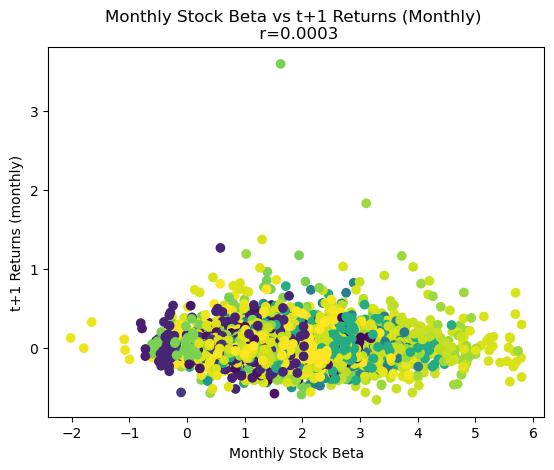

In [44]:
# Run Regression
model = stats.linregress(list(aggregate_df["beta"]), list(aggregate_df["T+1 RET"]))
r_val = f'{model[2]:.4f}'
p_val = f'{model[3]:.2f}'
corr_p_value_matrix_dict["beta vs T+1 Return"] = {"r": r_val, "pval": p_val}

print(f'r-value for beta and t+1 return is {r_val}, p={p_val}')

# Plot
# Coloured by permno
plt.scatter(x = aggregate_df["beta"], y = aggregate_df["T+1 RET"], c=aggregate_df["PERMNO"])


plt.title(f"Monthly Stock Beta vs t+1 Returns (Monthly) \n r={r_val}")
plt.xlabel("Monthly Stock Beta")
plt.ylabel("t+1 Returns (monthly)")
plt.show()

## Idiosyncratic Volatility vs T+1 Ret

r-value for ivol and t+1 return is 0.0411, p=0.00


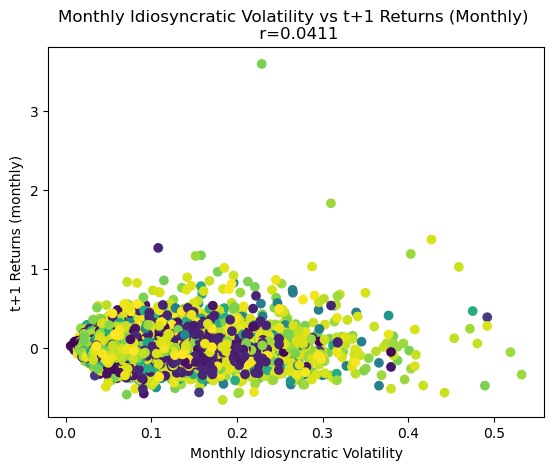

In [45]:
# Run Regression
model = stats.linregress(list(aggregate_df["ivol"]), list(aggregate_df["T+1 RET"]))
r_val = f'{model[2]:.4f}'
p_val = f'{model[3]:.2f}'
corr_p_value_matrix_dict["ivol vs T+1 Return"] = {"r": r_val, "pval": p_val}

print(f'r-value for ivol and t+1 return is {r_val}, p={p_val}')

# Plot
# Coloured by permno
plt.scatter(x = aggregate_df["ivol"], y = aggregate_df["T+1 RET"], c=aggregate_df["PERMNO"])


plt.title(f"Monthly Idiosyncratic Volatility vs t+1 Returns (Monthly) \n r={r_val}")
plt.xlabel("Monthly Idiosyncratic Volatility")
plt.ylabel("t+1 Returns (monthly)")
plt.show()

## Momentum vs T+1 Ret

r-value for mom and t+1 return is 0.0171, p=0.01


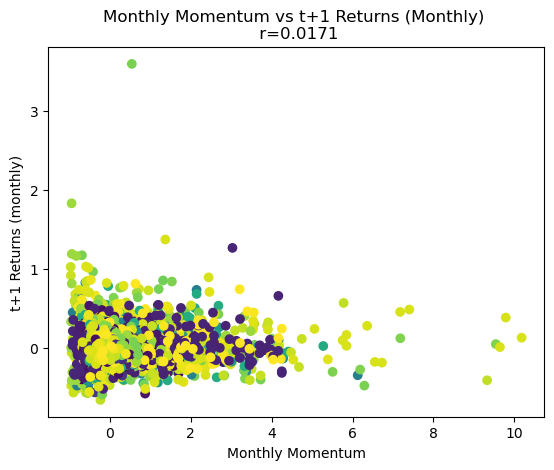

In [46]:
# Run Regression
model = stats.linregress(list(aggregate_df["mom"]), list(aggregate_df["T+1 RET"]))
r_val = f'{model[2]:.4f}'
p_val = f'{model[3]:.2f}'
corr_p_value_matrix_dict["mom vs T+1 Return"] = {"r": r_val, "pval": p_val}

print(f'r-value for mom and t+1 return is {r_val}, p={p_val}')

# Plot
# Coloured by permno
plt.scatter(x = aggregate_df["mom"], y = aggregate_df["T+1 RET"], c=aggregate_df["PERMNO"])


plt.title(f"Monthly Momentum vs t+1 Returns (Monthly) \n r={r_val}")
plt.xlabel("Monthly Momentum")
plt.ylabel("t+1 Returns (monthly)")
plt.show()

## lnSize vs T Ret
- We compare to the return at time t because in assignment 2 we already delayed the data due to earnings delays
- 3 month lag

r-value for lnSize and 3-month lagged return is -0.0044, p=0.53


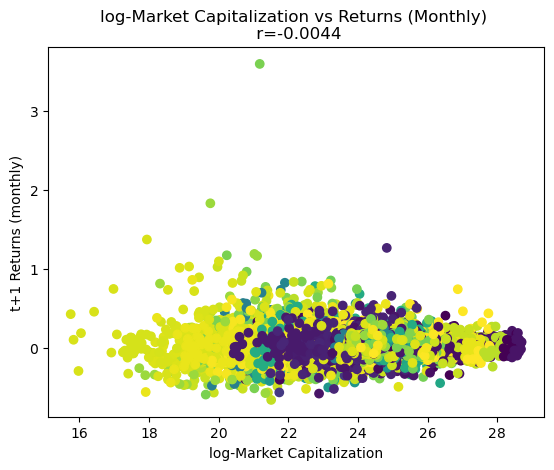

In [47]:
# Run Regression
model = stats.linregress(list(aggregate_df["lnSize"]), list(aggregate_df["RET"]))
r_val = f'{model[2]:.4f}'
p_val = f'{model[3]:.2f}'
corr_p_value_matrix_dict["lnSize vs Return"] = {"r": r_val, "pval": p_val}

print(f'r-value for lnSize and 3-month lagged return is {r_val}, p={p_val}')

# Plot
# Coloured by permno
plt.scatter(x = aggregate_df["lnSize"], y = aggregate_df["RET"], c=aggregate_df["PERMNO"])

plt.title(f"log-Market Capitalization vs Returns (Monthly) \n r={r_val}")
plt.xlabel("log-Market Capitalization")
plt.ylabel("t+1 Returns (monthly)")
plt.show()

## bk2mkt vs T Ret 
- We compare to the return at time t because in assignment 2 we already delayed the data due to earnings

r-value for bk2mkt and 3-month lagged return is 0.1078, p=0.00


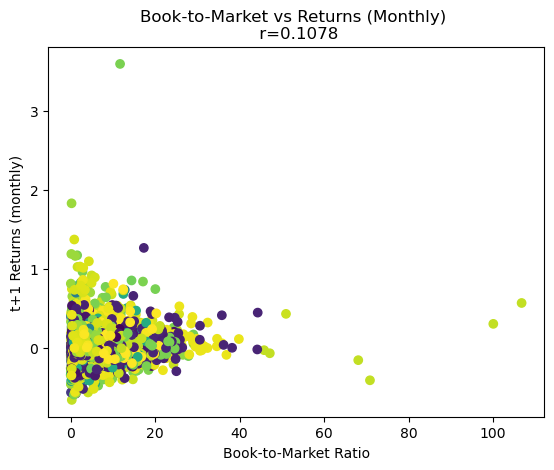

In [48]:
# Run Regression
model = stats.linregress(list(aggregate_df["bk2mkt"]), list(aggregate_df["RET"]))
r_val = f'{model[2]:.4f}'
p_val = f'{model[3]:.2f}'
corr_p_value_matrix_dict["bk2mkt vs Return"] = {"r": r_val, "pval": p_val}

print(f'r-value for bk2mkt and 3-month lagged return is {r_val}, p={p_val}')

# Plot
# Coloured by permno
plt.scatter(x = aggregate_df["bk2mkt"], y = aggregate_df["RET"], c=aggregate_df["PERMNO"])

plt.title(f"Book-to-Market vs Returns (Monthly) \n r={r_val}")
plt.xlabel("Book-to-Market Ratio")
plt.ylabel("t+1 Returns (monthly)")
plt.show()

## eP2 vs T
- Comparing to time t instead of t+1 for the same reason as above

r-value for eP2 and 3-month lagged return is -0.0303, p=0.00


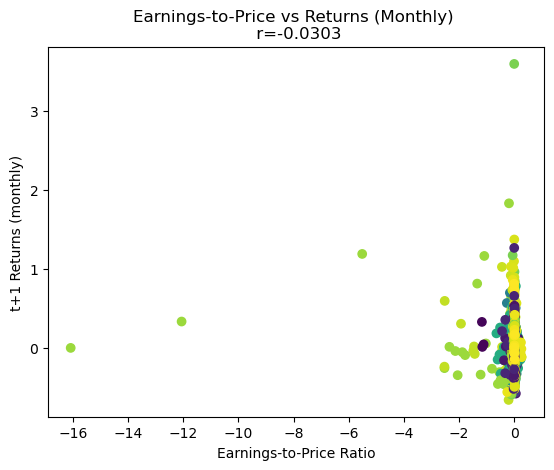

In [49]:
# Run Regression
model = stats.linregress(list(aggregate_df["eP2"]), list(aggregate_df["RET"]))
r_val = f'{model[2]:.4f}'
p_val = f'{model[3]:.2f}'
corr_p_value_matrix_dict["eP2 vs Return"] = {"r": r_val, "pval": p_val}

print(f'r-value for eP2 and 3-month lagged return is {r_val}, p={p_val}')

# Plot
# Coloured by permno
plt.scatter(x = aggregate_df["eP2"], y = aggregate_df["RET"], c=aggregate_df["PERMNO"])

plt.title(f"Earnings-to-Price vs Returns (Monthly) \n r={r_val}")
plt.xlabel("Earnings-to-Price Ratio")
plt.ylabel("t+1 Returns (monthly)")
plt.show()

***
## Significance Testing - NEW
- We already stored in our code above

In [50]:
corr_p_value_matrix = pd.DataFrame.from_dict(corr_p_value_matrix_dict)
corr_p_value_matrix

,beta vs T+1 Return,ivol vs T+1 Return,mom vs T+1 Return,lnSize vs Return,bk2mkt vs Return,eP2 vs Return
r,0.0003,0.0411,0.0171,-0.0044,0.1078,-0.0303
pval,0.96,0.00,0.01,0.53,0.00,0.00


## Explanation in report

---
## Significance T-Testing - OLD
- We can determine the significance of our r values by calculating the significance between our predictions and actual observations

In [51]:
# Beta
x = sm.add_constant(aggregate_df["beta"])
model2 = sm.OLS(aggregate_df["T+1 RET"], x).fit()
predictions = model2.predict(x)

ttest = stats.ttest_ind(predictions, np.zeros(len(predictions)))
ttest

Ttest_indResult(statistic=67442.79463840787, pvalue=0.0)

In [52]:
# ivol
x = sm.add_constant(aggregate_df["ivol"])
model2 = sm.OLS(aggregate_df["T+1 RET"], x).fit()
predictions = model2.predict(x)

ttest = stats.ttest_ind(predictions, np.zeros(len(predictions)))
ttest

Ttest_indResult(statistic=507.56122873688776, pvalue=0.0)

In [53]:
# mom
x = sm.add_constant(aggregate_df["mom"])
model2 = sm.OLS(aggregate_df["T+1 RET"], x).fit()
predictions = model2.predict(x)

ttest = stats.ttest_ind(predictions, np.zeros(len(predictions)))
ttest

Ttest_indResult(statistic=1222.1383541598452, pvalue=0.0)

In [54]:
# lnSize
x = sm.add_constant(aggregate_df["lnSize"])
model2 = sm.OLS(aggregate_df["RET"], x).fit()
predictions = model2.predict(x)

ttest = stats.ttest_ind(predictions, np.zeros(len(predictions)))
ttest

Ttest_indResult(statistic=4874.989985053718, pvalue=0.0)

In [55]:
# bk2mkt
x = sm.add_constant(aggregate_df["bk2mkt"])
model2 = sm.OLS(aggregate_df["RET"], x).fit()
predictions = model2.predict(x)

ttest = stats.ttest_ind(predictions, np.zeros(len(predictions)))
ttest

Ttest_indResult(statistic=197.43821629426904, pvalue=0.0)

In [56]:
# eP2
x = sm.add_constant(aggregate_df["eP2"])
model2 = sm.OLS(aggregate_df["RET"], x).fit()
predictions = model2.predict(x)

ttest = stats.ttest_ind(predictions, np.zeros(len(predictions)))
ttest

Ttest_indResult(statistic=702.8170822413236, pvalue=0.0)

***
## Outputting our datasets into one file


In [57]:
writer = pd.ExcelWriter('datasets-A3.xlsx')

# DataFrames to export
dataframes = {
    'crsp': crsp,
    'merged': merged,
    'ff3_daily': ff3_daily,
    'crsp_daily': crsp_daily,
    'ff3_crsp_daily_merged': ff3_crsp_merged,
    'aggregate_df (winsorized)': aggregate_df,
}

# Write each DataFrame to its own sheet
for sheet_name, df in dataframes.items():
    df.to_excel(writer, sheet_name=sheet_name, index=False)

writer.close()